# StackOverflow Analysis

Popular question and answer (qna) site - stackoverflow (& their sister sites - http://stackexchange.com/sites) witnesses tremendous activity daily where netizens post questions, recieve answers, comments and engage in an active discussion. 

We want to analyze this data with the intention to identify __related__ questions. In general, the analysis presented in this notebook can be used in a variety of scenarios. Some illustrative examples include

* Power users use multiple browser tabs simultaneously. Using the techniques outlined below, we can identify and group similar tabs together. With the appropriate visual cues, similar tabs can be identified at a glance.

* Many products provide a twitter handle to offer support. User questions about the product or service related queries (all within the twitter 140 char limit) can be grouped based on similarity.

The Stack Exchange network uploads monthly dumps of their data which we have used for analysis.

> "The anonymized dump of all user-contributed content on the Stack Exchange network. Each site is formatted as a separate archive consisting of XML files zipped via 7-zip using bzip2 compression. Each site archive includes Posts, Users, Votes, Comments, PostHistory and PostLinks. For complete schema information, see the included readme.txt.

> All user content contributed to the Stack Exchange network is cc-by-sa 3.0 licensed, intended to be shared and remixed. We even provide all our data as a convenient data dump."

** From : https://archive.org/details/stackexchange **


## Schema & Data Munging

The schema for their data is located @ https://ia800500.us.archive.org/22/items/stackexchange/readme.txt.
    
However,

* All the data is dumped in XML format. So we need to write a converter to convert the XML data into a tabular format.
* Since the size of data is huge, we need to load data in a streaming fashion. 
* All the exchange sites share identical schema!


The first step is to then write a converter which does this. Our [Streaming XML2CSV Converter](convertso2csv.py) expects input data to be present at [input/english](input/english) for english.stackexchange.com, [input/aviation](input/aviation) for aviation.stackexchange.com etc. Similarly, the converted data is dumped at [output/english](output/english) and [output/aviation](output/aviation) respectively.

Also, note the converter outputs the csv file in a zipped format as pandas (the lib we use to read data) understands zip formats natively.

Please download the data from https://archive.org/download/stackexchange/english.stackexchange.com.7z and https://archive.org/download/stackexchange/aviation.stackexchange.com.7z into the input folders to run the dashboard. Alternatively, a sample run output has been stored in the respective output folders.


In [8]:
#imports
import warnings
warnings.filterwarnings('ignore')

import os
import os.path

import pandas as pd
import numpy as np
import math
import re

import gensim
from gensim import corpora, models,similarities
from gensim.models import Doc2Vec, TfidfModel

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer

from pprint import pprint                        # pretty-printer

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from wordcloud import WordCloud

SAMPLE_SIZE = 20000
RECOMPUTE_MODEL = True

SITE1 = 'biology' #.stackexchange.com
SITE2 = 'bicycles' #.stackexchange.com
SITES = [SITE1, SITE2]

samples = {}
samples[SITE1] = [
    'Why are the human knees and elbows bent in an opposite direction',
    'How would one determine whether a chemical will upregulate a certain class of proteins?'
]
samples[SITE2] = [
    'Picking a bike for a cyclist new to riding on the road?',
    'max weight that the shimano Rs400 can carry ?'
]


stopw = {}
stopw[SITE1] = ['biology', 'human', 'cell', 'dna', 'protein','doe']
stopw[SITE2] = ['bike','bicycle','bikes','bicycles']

In [9]:
# Global variables
Posts = {}
NormalizedPosts = {}
Dictionaries = {}
Corpora = {}
TFIDF = {}
NUM_TOPICS = {}
STOPW = {}

## 0. Convert Data from XML to CSV

In [10]:
#%%bash
#set XXX = 'chemistry'
#curl https://archive.org/download/stackexchange/$XXX.stackexchange.com.7z

In [11]:
from convertso2csv import process

# To get a new network, do the following
# wget https://archive.org/download/stackexchange/XXX.stackexchange.com.7z  [XXX=chemistry, physics etc]
# Extract the zip into input/XXX folder and then run this cell.
process(os.getcwd() + '/input')

skipping aviation...
skipping english...
skipping astronomy...
skipping biology...
skipping chemistry...
skipping bicycles...


# Data loading

For the purposes of this analysis, we use only post title and body. However, we will show the other data also made available to us from stackexchange. This can be used to further enrich the analysis. But this is not done in the current notebook.

### Note :

The original data is large. So to play around with the data, we have provide some knobs to tune within the notebooks (versus putting them in the parser)

1. ** SAMPLE_SIZE **  (#default value as 20k records)
2. ** SITE1 ** (#default value is english)
3. ** SITE2 ** (#default value is aviation)

Feel free to change this value to experiment or get better results.

### 1. Load SITE1 stackexchange data.

In [12]:
path = 'output/'+SITE1+'/'+'posts.csv.gz'
Posts[SITE1] = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['Body','Title'])
Posts[SITE1]['Tags'] = Posts[SITE1]['Tags'].apply(lambda x : x.replace('<',' ').replace('>',' '))
Posts[SITE1][['Body','Title', 'Tags']].head(2)

,Body,Title,Tags
0,in prokaryotic translation how critical for e...,what is the criticality of the ribosome bindin...,ribosome binding-sites translation synthet...
1,does anyone have any suggestions to prevent rn...,how is rnase contamination in rna based experi...,rna biochemistry


### 2. Load the SITE2 stackexchange data.

In [13]:
path = 'output/'+SITE2+'/'+'posts.csv.gz'
Posts[SITE2] = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['Body','Title'])
Posts[SITE2]['Tags'] = Posts[SITE2]['Tags'].apply(lambda x : x.replace('<',' ').replace('>',' '))
Posts[SITE2][['Body','Title', 'Tags']].head(2)

,Body,Title,Tags
0,i keep losing pressure in my tires and among ...,can i use a presta tube in a schrader rim,mountain-bike innertube presta schrader
1,are there adjustments that can be made instead...,what is the easiest way to fix a loose chain,chain


Related data can also be loaded. However, for the purposes of this demonstration, we are not exploiting the data from the tables below.

In [14]:
path = 'output/'+SITE2+'/'+'comments.csv.gz'
comments = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna()
comments[['Score','Text']].head(5)

,Score,Text
0,0,do you mean measure a frame of unknown dimensi...
1,0,the specified height of a frame i already bou...
2,0,thanks i ll do that
3,2,be sure to bend and flex the casing of the tir...
4,0,what kind of valve i know only very very old...


In [15]:
path='output/'+SITE1+'/'+'posthistory.csv.gz'
posthistory = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['Text'])
posthistory[['Text']].head(5)

,Text
0,i was wondering whether you know how critical ...
1,ribosome binding site
3,does anyone have any suggestions to prevent rn...
4,preventing rnase contamination in rna based ex...
6,tortora writes in principles of anatomy and p...


In [16]:
path='output/' + SITE1 + '/' + 'users.csv.gz'
users = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['AboutMe','Location'])
users[['Location','AboutMe']].head(5)

,Location,AboutMe
0,on the server farm,hi i m not really a person i m a background ...
1,,being an alice in the world of computing can ...
2,new york united states,i m a former stack exchange employee for all...
3,corvallis or,developer on the stack overflow team find me...
4,winston salem nc,stack overflow valued associate twitter nick...


### Note

The relationship between all these tables and the detailed meaning of all the attributes and values can be found @
https://ia800500.us.archive.org/22/items/stackexchange/readme.txt
    

## Data cleansing - Stop Words & Word Stems

Once the data is loaded, we want to remove all the stop words present in the raw data. The ** stop_words ** instance can be used for the remainder of the program to achieve this.

In [17]:
class StopWords():
    lemma = WordNetLemmatizer()
    #stemmer = SnowballStemmer("english")
    #stemmer = LancasterStemmer()
    
    def __init__(self,add=[]):
        self.stop_words = stopwords.words('english')
        self.stop_words.append('use')
        for word in add:
            self.stop_words.append(word)

    def remove(self, sentence):
        line = [StopWords.lemma.lemmatize(tok) for tok in sentence.split()]
        return [tok for tok in line if not tok in self.stop_words and len(tok) > 1]    

In [18]:
class SentenceTokens():
    def __init__(self,df,field,sw):
        self.field = field
        self.df = df
        self.sw = sw
    
    def posts(self):
        for index, row in self.df.iterrows():
            raw_sentence = row[self.field]            
            tokens = [tok for tok in self.sw.remove(raw_sentence)]            
            allsame = [tok for tok in tokens if tok != tokens[0]]
            if len(tokens) >=2 and len(allsame) > 0 : #at least 2 words, huh?
                yield raw_sentence
    
    def __iter__(self):
        for index, row in self.df.iterrows():
            raw_sentence = row[self.field]            
            tokens = [tok for tok in self.sw.remove(raw_sentence)]            
            allsame = [tok for tok in tokens if tok != tokens[0]]
            if len(tokens) >=2 and len(allsame) > 0 : #at least 2 words, huh?
                yield tokens


In [19]:
def get_dictionary(site, posts, force=False):
    dictFile = 'models/' + site + '_posts.dict'

    # Check if trained model file exists
    if ( os.path.isfile(dictFile) and not force):
        dictionary = corpora.Dictionary.load(dictFile)
    else:
        #How frequently each term occurs within each document? We construct a document-term matrix.
        dictionary = corpora.Dictionary(posts)
        #dictionary.filter_extremes(no_below=5, no_above=10)
        # store the dictionary, for future reference
        dictionary.save(dictFile) 

    return dictionary

# Bag of words
# corpus is a list of vectors equal to the number of documents. 
# In each document vector is a series of tuples. 
def get_corpus(site, posts, force=False):
    corpusFile = 'models/' + site + '_posts.mm'
    
    # Check if corpus file is found
    if ( os.path.isfile(corpusFile) and not force ):
        corpus = corpora.MmCorpus(corpusFile)
    else:
        # Create corpus
        corpus = [Dictionaries[site].doc2bow(post) for post in posts]
        # Store corpus to file
        corpora.MmCorpus.serialize(corpusFile, corpus) #Save the bow corpus
        
    return corpus

In [20]:
for site in SITES:
    STOPW[site] = StopWords(stopw.get(site,[]))
    NormalizedPosts[site] = SentenceTokens(Posts[site],'Title',STOPW[site])
    Dictionaries[site] = get_dictionary(site, NormalizedPosts[site], force=RECOMPUTE_MODEL)
    Corpora[site] = get_corpus(site, NormalizedPosts[site], force=RECOMPUTE_MODEL)
    TFIDF[site] = TfidfModel(Corpora[site], normalize=RECOMPUTE_MODEL)

In [21]:
# Has to be better way to do this
def getWordOccurencesInCorpus(site):
    wordfreq = {}
    for row in Corpora[site]:
        for words in row:
            w = Dictionaries[site].get(words[0])
            if w in wordfreq:
                wordfreq[w] += words[1]
            else:
                wordfreq[w] = 1        
    freqs = []
    for k in wordfreq:
        freqs.append((k,(wordfreq[k])))
    return freqs

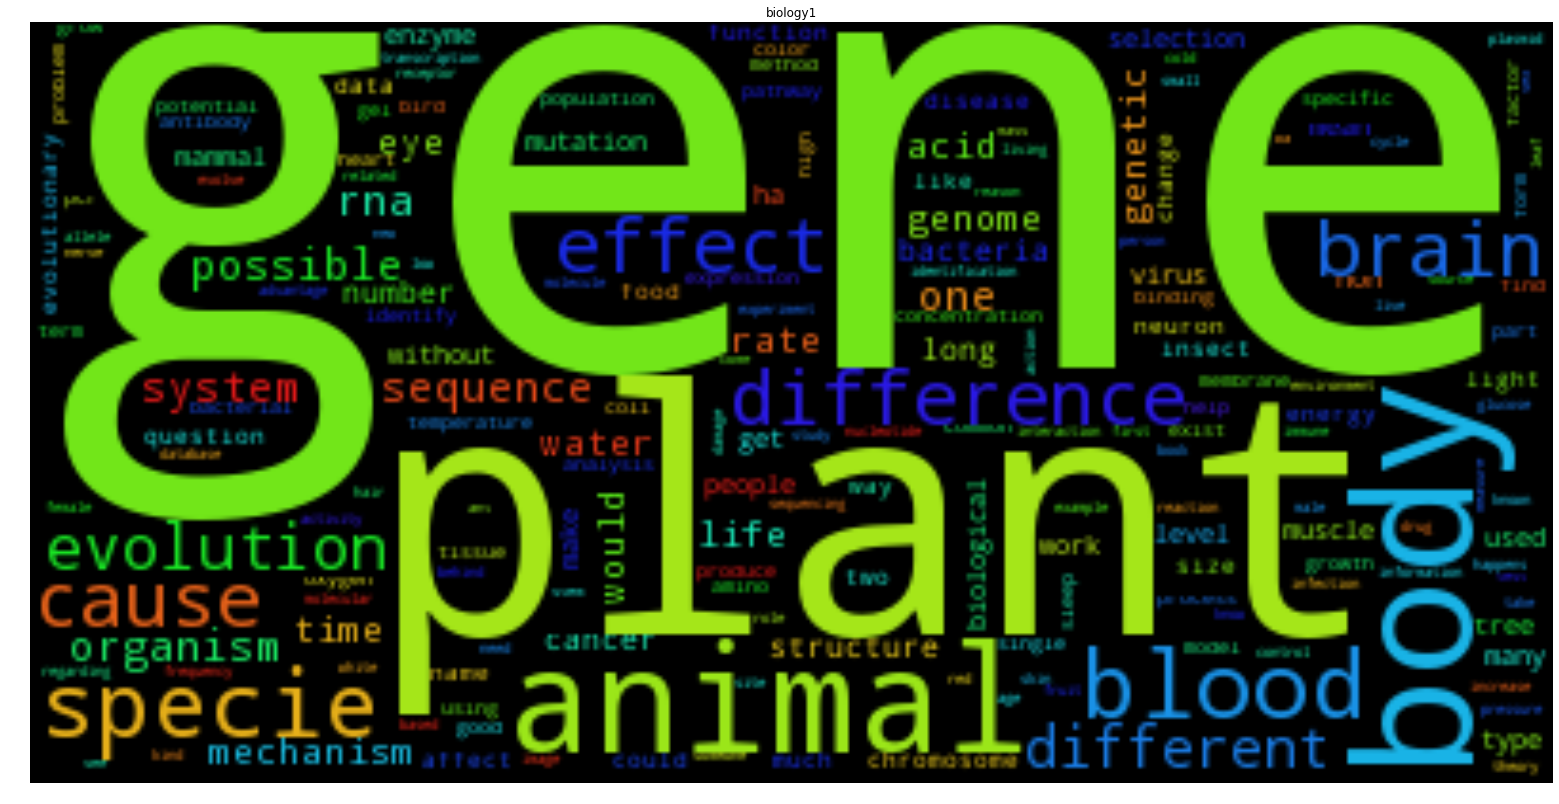

In [22]:
fig = plt.figure(figsize=(20*3, 30))
plotId=1
for site in [SITE1]:
    wfreq = getWordOccurencesInCorpus(site)
    plt.subplot(120+plotId)
    plt.imshow(WordCloud().fit_words(wfreq))
    plt.axis("off")
    plt.title(site + `plotId`)
    plotId +=1
    
plt.show()

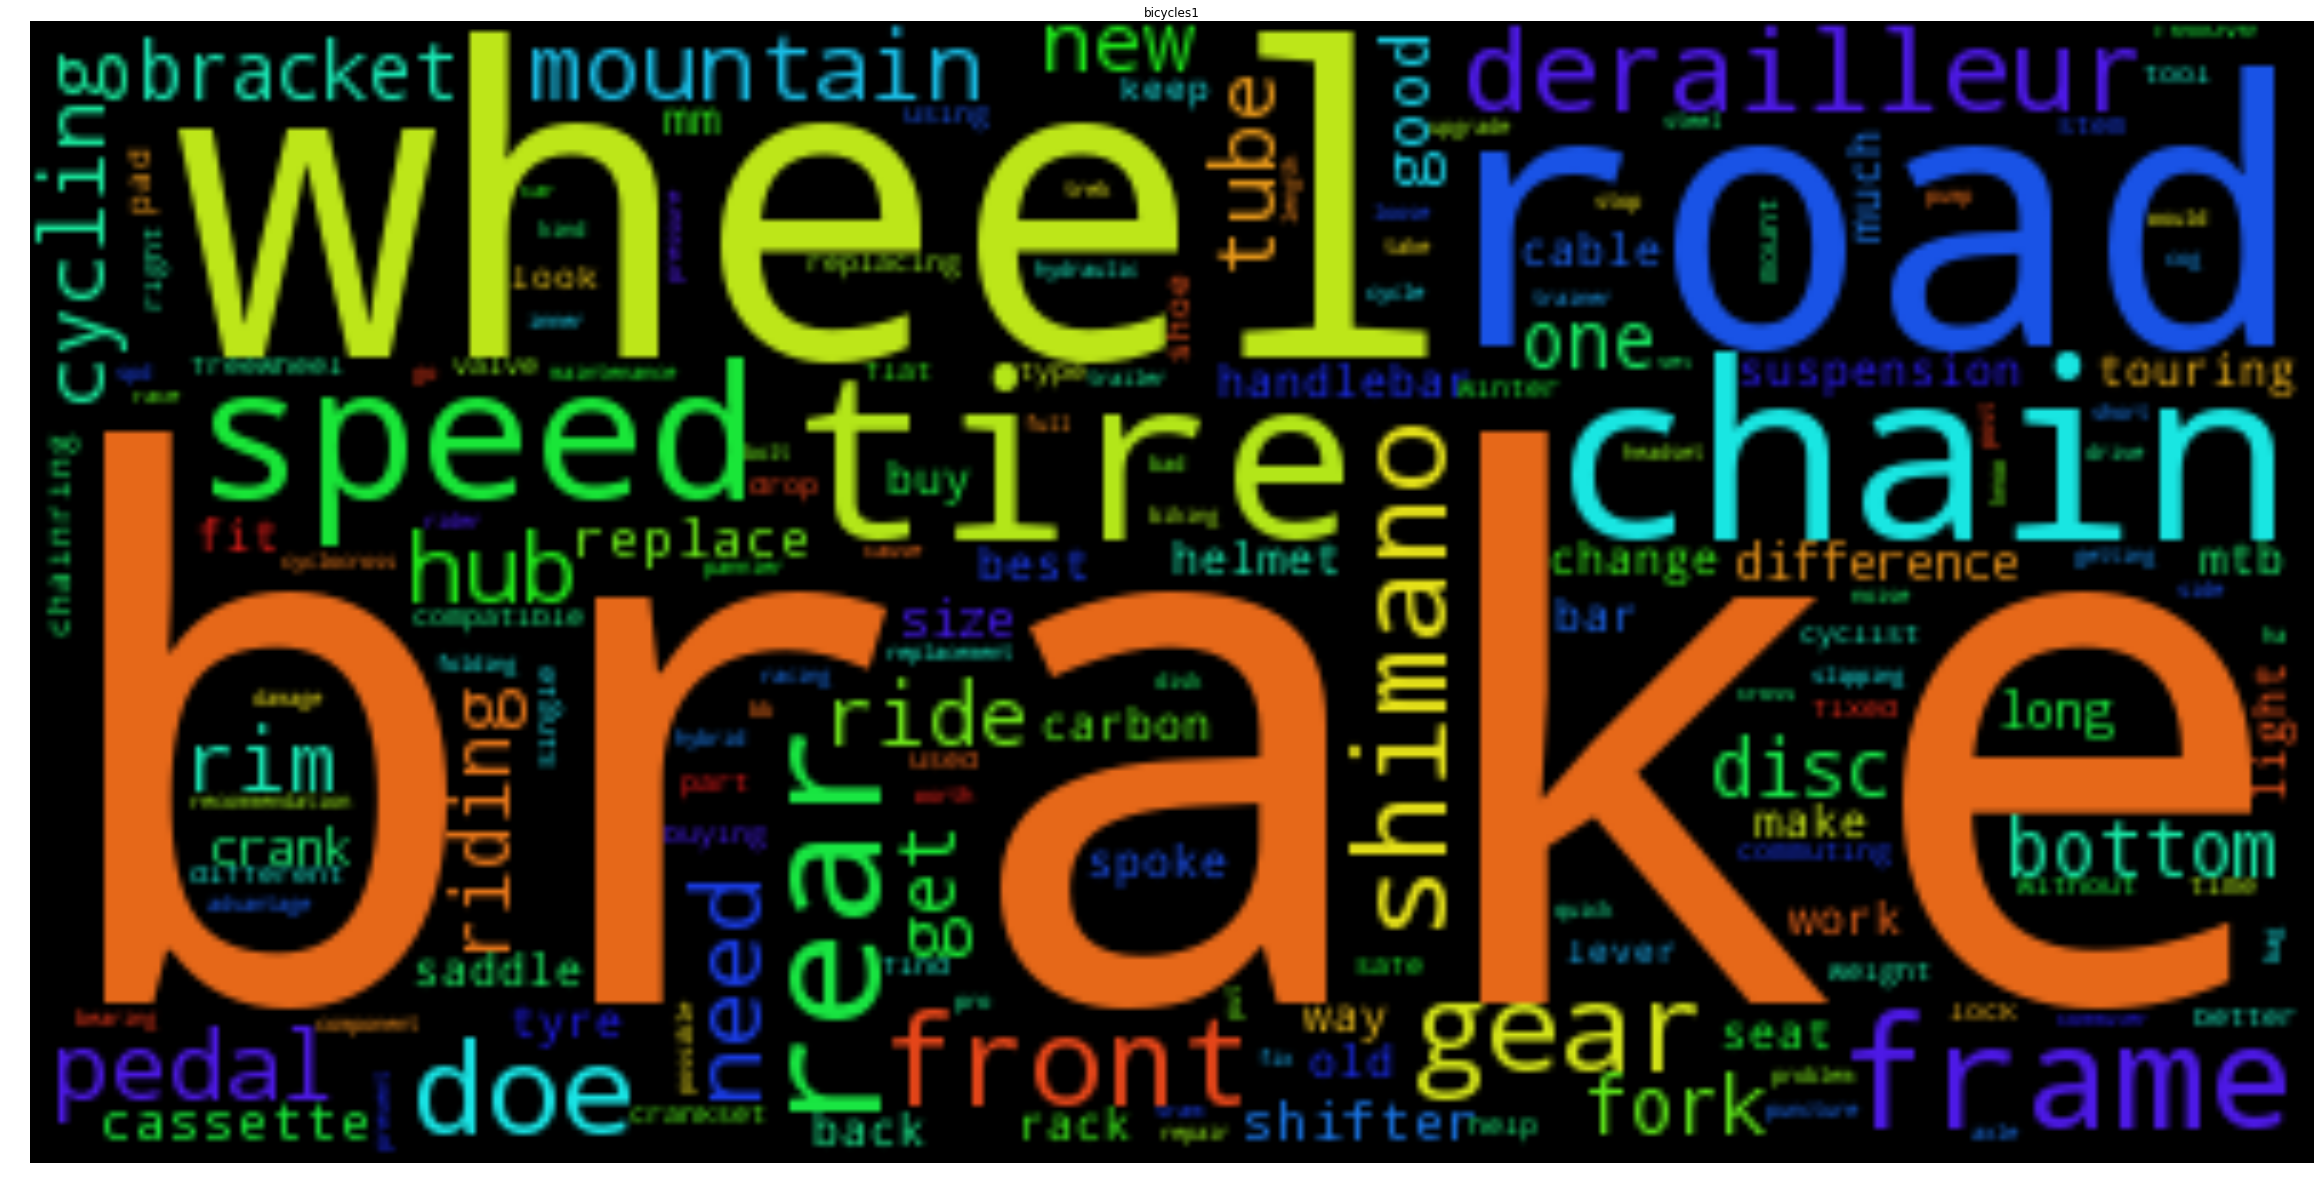

In [23]:
fig = plt.figure(figsize=(30*3, 30))
plotId=1
for site in [SITE2]:
    wfreq = getWordOccurencesInCorpus(site)
    plt.subplot(120+plotId)
    plt.imshow(WordCloud().fit_words(wfreq))
    plt.axis("off")
    plt.title(site + `plotId`)
    plotId +=1
    
plt.show()

## 1. Find out the number of topics
===========================================

We were not aware of the number of topic, so we decided to reduce the number of features to two dimensions, then clustering the points for different values of K (number of clusters) to find an optimum value. 

One such transform is the Latent Semantic Indexing (LSI) transform, which we use to project the original data to 2D.

In [24]:
def get_lsi_model(site, dictionary, corpus, force = False):
    lsimodelFile = 'models/' + site + '_lsi.model'
    
    # Check if corpus file is found
    if ( os.path.isfile(lsimodelFile) and not force):
        lsimodel = models.LsiModel.load(lsimodelFile)
    else:
        lsimodel = models.LsiModel(TFIDF[site][Corpora[site]], id2word=dictionary, num_topics=NUM_TOPICS[site])
        lsimodel.save(lsimodelFile)

    return lsimodel

In [25]:
# Get LSI Model
LsiModels = {}

for site in SITES:
    NUM_TOPICS[site] = 2
    LsiModels[site] = get_lsi_model(site, Dictionaries[site], Corpora[site], force=RECOMPUTE_MODEL)

In [26]:
def getWordCloud(line):
    scores = [float(x.split("*")[0]) for x in line.split(" + ")]
    words = [x.split("*")[1] for x in line.split(" + ")]
    freqs = []
    for word, score in zip(words, scores):
        if word.startswith('"') and word.endswith('"'):
            word = word[1:-1]
        freqs.append((word, score))
    return WordCloud().fit_words(freqs)    

def plotWordCloud(site, model, num_topics = None, num_words=6):
    plotId = 1
    figureId = 1
    if num_topics is None:
        num_topics = NUM_TOPICS[site]

    for line in model.print_topics(num_topics,num_words):
            if plotId % 2 != 0:            
                plotId = 1
                plt.figure(figureId,figsize=(5*3, 5))

            plt.subplot(120+plotId)
            plt.imshow(getWordCloud(line[1]))
            plt.axis("off")
            plt.title(site + `figureId`)
            plotId += 1
            figureId +=1

    plt.show()

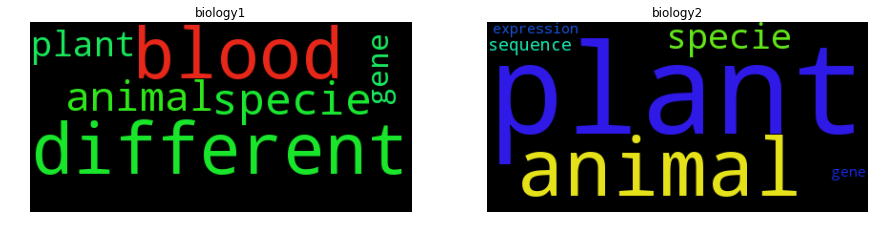

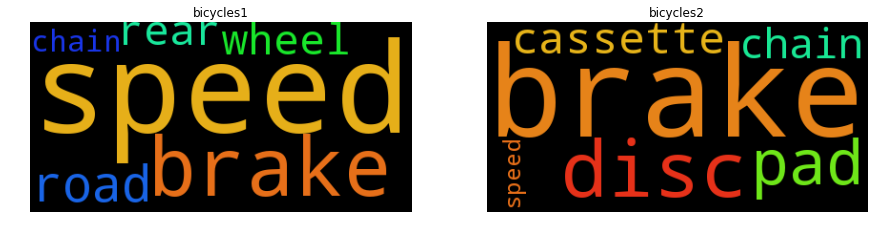

In [27]:
for site in SITES:
  plotWordCloud(site, LsiModels[site], 3)


We clustered the points in the this reduced space using KMeans, varying the number of clusters (K) from 1 to 10. 
We used the Inertia of the cluster provided by Scikit-Learn KMeans algorithm. 

** Ref ** : http://stackoverflow.com/questions/6645895/calculating-the-percentage-of-variance-measure-for-k-means


In [28]:
#pprint(Corpora[SITE1])
#pprint(LsiModels[SITE1][Corpora[SITE1]])
#for row in LsiModels[site][Corpora[SITE1]]:
#    print(row)

## From the above analysis, we will use number of clusters as 5

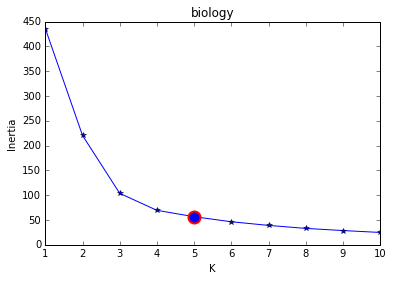

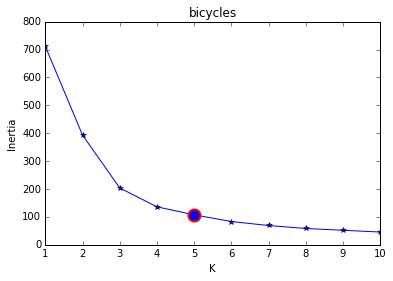

In [29]:
X = {}

for site in SITES:
    D = ''
    for vector in LsiModels[site][Corpora[site]]:
        if 2 == len(vector):
            #'1 2; 3 4' => 2 X 2
            D = D + `round(vector[0][1],4)` + ' ' + `round(vector[1][1],4)` + ';'
        else:
            print(vector)


    X[site] = np.matrix(D[:-1])

    MAX_K = 10
    ks = range(1, MAX_K + 1)

    inertias = np.zeros(MAX_K)
    diff = np.zeros(MAX_K)
    diff2 = np.zeros(MAX_K)
    diff3 = np.zeros(MAX_K)
    for k in ks:
        kmeans = KMeans(k).fit(X[site])
        inertias[k - 1] = kmeans.inertia_
        # first difference    
        if k > 1:
            diff[k - 1] = inertias[k - 1] - inertias[k - 2]
        # second difference
        if k > 2:
            diff2[k - 1] = diff[k - 1] - diff[k - 2]
        # third difference
        if k > 3:
            diff3[k - 1] = diff2[k - 1] - diff2[k - 2]

    elbow = np.argmin(diff3[3:]) + 3

    plt.plot(ks, inertias, "b*-")
    plt.plot(ks[elbow], inertias[elbow], marker='o', markersize=12,
             markeredgewidth=2, markeredgecolor='r', markerfacecolor=None)
    plt.ylabel("Inertia")
    plt.xlabel("K")
    plt.title(site)
    plt.show()

In [30]:
print(Corpora[SITE1][49])
print(X[SITE1].shape[0])
print(len(LsiModels[SITE1][Corpora[SITE1]]))

[(144, 1), (225, 1), (226, 1), (227, 1), (228, 1), (229, 1), (230, 1), (231, 1), (232, 1)]
8223
8223


In [31]:
NUM_TOPICS = {}
NUM_TOPICS[SITE1] = 5
NUM_TOPICS[SITE2] = 5

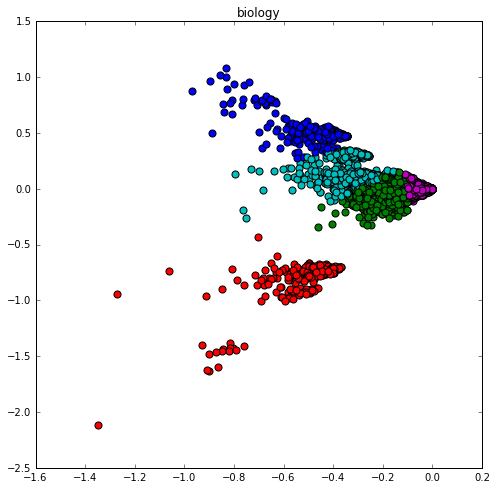

In [32]:
fig = plt.figure(figsize=(8, 8))
kmeans = KMeans(NUM_TOPICS[SITE1]).fit(X[SITE1])
labels = kmeans.labels_
colors = ["b", "g", "r", "m", "c", "p", "y"] #Not expecting more than 5 for the data size
for i in range(X[SITE1].shape[0]):
    plt.scatter(X[SITE1][i,0] ,X[SITE1][i,1], c=colors[labels[i]], s=50)    
plt.title(SITE1)
plt.show()

In [33]:
Buckets = {}
for k in range(NUM_TOPICS[SITE1]):
    Buckets[k] = []
    
for index, sentence  in enumerate(NormalizedPosts[SITE1].posts()):
    Buckets[labels[index]].append(sentence)    

for key in Buckets:
    print('LABEL : ' + `key`)
    print('-------------------')
    print("\n".join(Buckets[key][:5]))   
    

LABEL : 0
-------------------
do large animals often evolve into smaller animals 
do plants produce any heat 
how does the sensitive plant detect vibrations 
why did the process of sleep evolve in many animals  what is its evolutionary advantage 
is batesian mimicry a form a parasitism  to what extent is the species with real defenses harmed by the defenceless species 
LABEL : 1
-------------------
what is the criticality of the ribosome binding site relative to the start codon in prokaryotic translation 
how is rnase contamination in rna based experiments prevented 
are lymphocyte sizes clustered in two groups 
how long does antibiotic dosed lb maintain good selection 
how many times did endosymbiosis occur 
LABEL : 2
-------------------
what is the reason behind choosing the reporter gene when experimenting on your gene of interest 
what are the limiting factors for gene length and number of exons 
how are the boundaries of a gene determined 
time from stimulus to gene expression
how

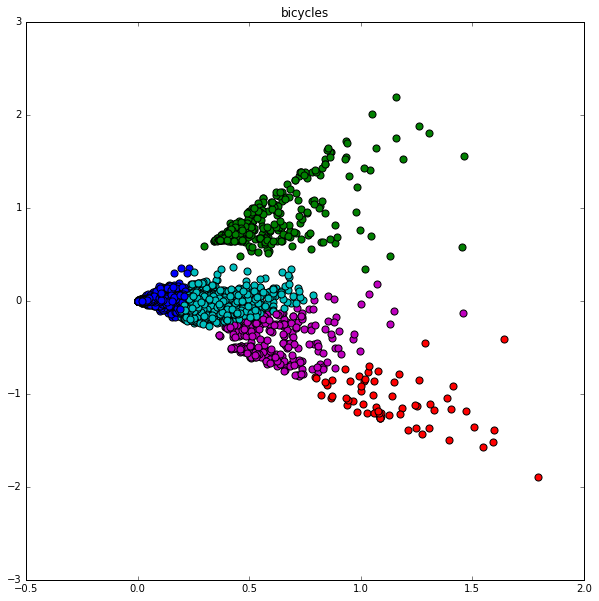

In [34]:
fig = plt.figure(figsize=(10, 10))
kmeans = KMeans(NUM_TOPICS[SITE2]).fit(X[SITE2])
y = kmeans.labels_
colors = ["b", "g", "r", "m", "c", "p", "y"] #Not expecting more than 5 for the data size
for i in range(X[SITE2].shape[0]):
    plt.scatter(X[SITE2][i,0] ,X[SITE2][i,1], c=colors[y[i]], s=50)    
plt.title(SITE2)
plt.show()

In [35]:
Buckets = Buckets or {}
for k in range(NUM_TOPICS[SITE2]):
    Buckets[k] = []
    
for index, sentence  in enumerate(NormalizedPosts[SITE2].posts()):
    Buckets[labels[index]].append(sentence)    

for key in Buckets:
    print('LABEL : ' + `key`)
    print('-------------------')
    print("\n".join(Buckets[key][:5]))   

LABEL : 0
-------------------
tightening a nut too much
    wheels on bike made for     wheels
touring load weight distribution
transporting groceries
plastic taste in my backpack water bladder
LABEL : 1
-------------------
can i use a presta tube in a schrader rim 
what is the easiest way to fix a loose chain 
how do i measure the size of my bicycle frame 
how to get a bike from one city to another in the u s
what is a good rear wheel for a heavy load 
LABEL : 2
-------------------
which country has the cheapest top end mountain bikes 
should i clean the grease off the gears 
how to fix new chain that switches gears when pedaling backwards
tactics for riding in strong winds
what is a reasonable speed for long distances on a bike 
LABEL : 3
-------------------
how do i reduce slack in the chain of a single speed bicycle 
slow leak on front cruiser tire
all mountain bomber recommendations
how do i prevent the rear derailleur from slipping gears 
perfectly setting up gears   how 
LABEL :

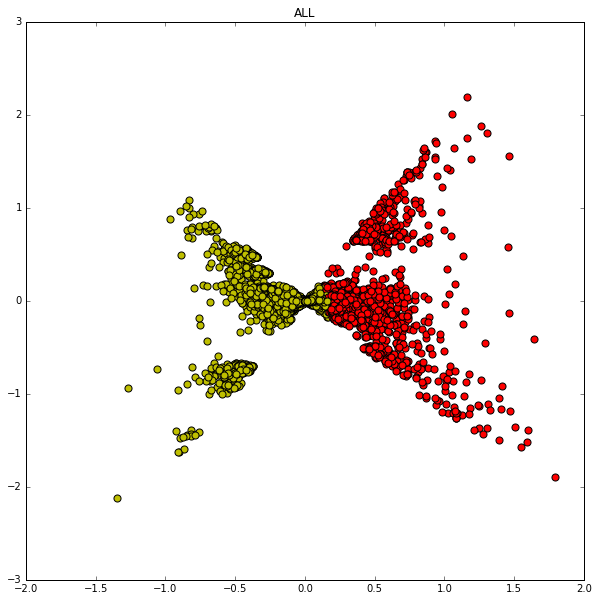

In [36]:
fig = plt.figure(figsize=(10, 10))
D = ''
for site in SITES:    
    for vector in LsiModels[site][Corpora[site]]:
        if 2 == len(vector):
            #'1 2; 3 4' => 2 X 2
            D = D + `round(vector[0][1],4)` + ' ' + `round(vector[1][1],4)` + ';'

X['ALL'] = np.matrix(D[:-1])
kmeans = KMeans(2).fit(X['ALL'])
y = kmeans.labels_
colors = ["r", "y",] 
#plt.subplot(120+plotId)
for i in range(X['ALL'].shape[0]):
    plt.scatter(X['ALL'][i,0] ,X['ALL'][i,1], c=colors[y[i]], s=50)    
plt.title('ALL')
plt.show()

## 2. Sample Search Demonstration
=============================================

In this section, we take a sample question, remove the stop words, and search using the LSI Model just created. We visually inspect the output for correctness.

In [37]:
def QSim(site, document): # Query function for document
    # Apply stop words
    doc_processed = STOPW[site].remove(document)
    # create vector
    vec_bow = Dictionaries[site].doc2bow(doc_processed)
    # convert the query (sample vector) to LSI space
    vec_lsi = LsiModels[site][vec_bow]
    corpus = Corpora[site]
    # find indexes of similar sims
    index = similarities.MatrixSimilarity(LsiModels[site][corpus]) 
    # perform a similarity query against the corpus
    sims = index[vec_lsi]
    return sims

In [38]:
site = SITE2
target = samples[site][1]
# Search for similar documents
sims = QSim(site,target)
# Sort in descending order - highest matching percentage on top
sorted_sims = sorted(enumerate(sims), key=lambda item: -item[1])
sims_list = list(enumerate(sorted_sims))

print("Search results for [{}]:".format(target))

# Show top 10 matches only
for i in range(0, 10):
    docid = sims_list[i][1][0]
    matchPercentage = sims_list[i][1][1]
    print("{:10.3f}% : {}".format(matchPercentage * 100, Posts[site].iloc[docid]['Title']))

Search results for [max weight that the shimano Rs400 can carry ?]:
   100.000% : can i convert flat bar to drop bars on a hybrid bike
   100.000% : how do i prevent sti shifter cables from blocking access to my randoneering bag or handlebar bag 
   100.000% : rattling of a shimano nexave roller brake
   100.000% : how to prevent the quick release pin on the tektro drop brake lever from rattling 
   100.000% : will loose handlebars result in slower riding 
   100.000% : tire feedback when cornering
   100.000% : what considerations are important when purchasing a new chain 
   100.000% : chain noise i identified the problem  don t know how to solve it  chain cassette  
   100.000% : i m going to take my bike with me on a plane  do i really need a special bike travel bag to have it transported safely 
    99.999% : the paint on my bicycle is damaged


## 3. Run the entire corpus against LDA to identify topics

The LDA algorithm is run with the number of topics set to the value found in the preceding steps.

In [39]:
def get_lda_model(site, dictionary, corpus, force=False):
    modelFile = 'models/' + site + '_lda.model'
    
    # Check if trained model file exists
    if ( os.path.isfile(modelFile) and not force):
        # load trained model from file
        ldamodel =  models.LdaModel.load(modelFile)
    else:
        # Create model
        
        #num_topics: required. An LDA model requires the user to determine how many topics should be generated. 
        #id2word: required. The LdaModel class requires our previous dictionary to map ids to strings.
        #passes: optional. The number of laps the model will take through corpus.
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS[site], id2word = dictionary, passes=30)

        # save model to disk (no need to use pickle module)
        ldamodel.save(modelFile)

    return ldamodel

In [40]:
# Get LDA Models
LdaModels = {}
for site in SITES:
    LdaModels[site] = get_lda_model(site, Dictionaries[site], Corpora[site], force=RECOMPUTE_MODEL)

In [41]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

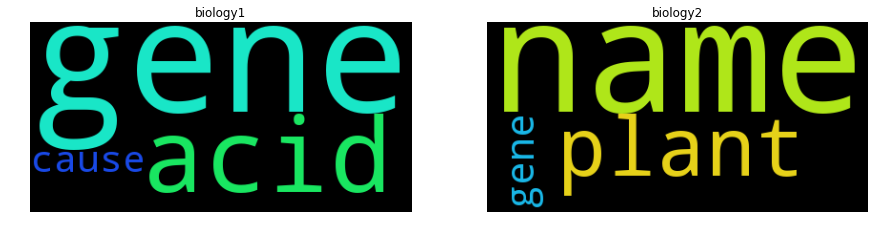

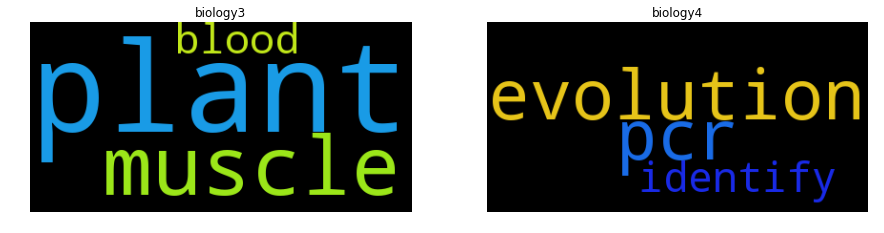

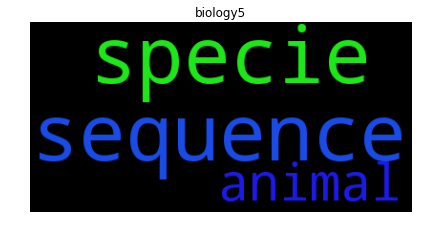

[(0, u'0.014*gene + 0.007*acid + 0.007*cause'),
 (1, u'0.011*name + 0.010*plant + 0.008*gene'),
 (2, u'0.013*plant + 0.011*muscle + 0.010*blood'),
 (3, u'0.011*evolution + 0.008*pcr + 0.007*identify'),
 (4, u'0.014*sequence + 0.010*specie + 0.009*animal')]

In [42]:
@interact(num_topics=NUM_TOPICS[SITE1] + 5, num_words=3)
def understand(num_topics, num_words):   
   plotWordCloud(SITE1,LdaModels[SITE1],num_topics,num_words)
   return LdaModels[SITE1].print_topics(num_topics, num_words)

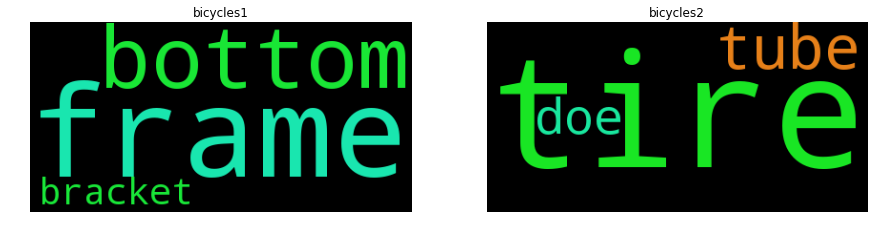

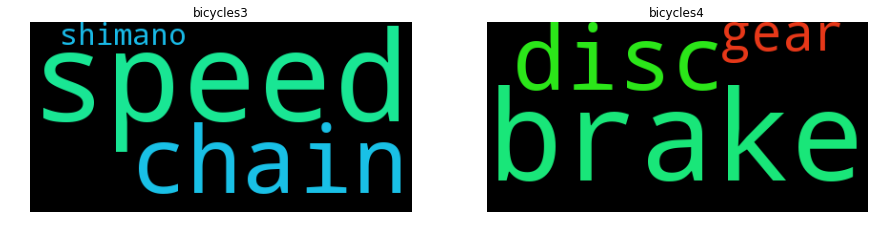

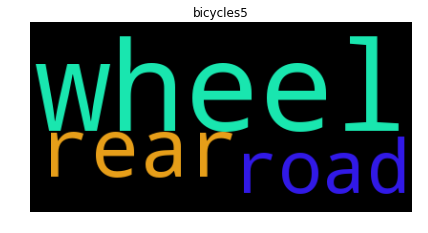

[(0, u'0.031*frame + 0.019*bottom + 0.018*bracket'),
 (1, u'0.026*tire + 0.017*tube + 0.014*doe'),
 (2, u'0.043*speed + 0.030*chain + 0.021*shimano'),
 (3, u'0.062*brake + 0.016*disc + 0.014*gear'),
 (4, u'0.044*wheel + 0.022*rear + 0.021*road')]

In [43]:
@interact(num_topics=NUM_TOPICS[SITE2] + 5, num_words=3)
def understand(num_topics, num_words):
   plotWordCloud(SITE2,LdaModels[SITE2],num_topics,num_words)
   return LdaModels[SITE2].print_topics(num_topics, num_words)

## 4. Visualize the Model

LDAvis is a web-based interactive visualization of topics estimated using Latent Dirichlet Allocation. The visualization provides a global view of the topics (and how they differ from each other), while at the same time allowing for a deep inspection of the terms most highly associated with each individual topic.

** Ref ** : 2014 ACL Workshop on Interactive Language Learning, Visualization, and Interfaces http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [44]:
#for site in SITES:
site = SITE1
pyLDAvis.gensim.prepare(LdaModels[site],Corpora[site],Dictionaries[site])

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      23.536285        1       1 -0.015398  0.108012
4      20.925335        1       2  0.163442  0.078683
1      19.629552        1       3 -0.193634 -0.127034
2      19.082659        1       4 -0.086723  0.127382
3      16.826168        1       5  0.132313 -0.187042, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
8747  Default  124.000000        sequence  124.000000  30.0000  30.0000
6528  Default   87.000000          muscle   87.000000  29.0000  29.0000
7359  Default   87.000000            name   87.000000  28.0000  28.0000
1238  Default  213.000000           plant  213.000000  27.0000  27.0000
4180  Default  122.000000       evolution  122.000000  26.0000  26.0000
5681  Default  130.000000           blood  130.000000  25.0000  25.0000
1794  Default  127.000000          animal  127.000000  24.0000  24.0000
7710  Default   64.000000          energy   64.000000  23.0000  23.0000
3969  Default  251.000000            gene  251.000000  22.0000  22.0000
5632  Default   86.000000             eye   86.000000  21.0000  21.0000
7542  Default   54.000000             pcr   54.000000  20.0000  20.0000
5835  Default   98.000000        organism   98.000000  19.0000  19.0000
8723  Default   58.000000            book   58.000000  18.0000  18.0000
1149  Default   60.000000          mammal   60.000000  17.0000  17.0000
2668  Default   65.000000            acid   65.000000  16.0000  16.0000
376   Default   56.000000            life   56.000000  15.0000  15.0000
5581  Default   63.000000      biological   63.000000  14.0000  14.0000
2746  Default   56.000000             way   56.000000  13.0000  13.0000
2064  Default   55.000000            site   55.000000  12.0000  12.0000
5114  Default   53.000000            grow   53.000000  11.0000  11.0000
4848  Default   47.000000        identify   47.000000  10.0000  10.0000
4861  Default   53.000000          allele   53.000000   9.0000   9.0000
7436  Default   53.000000      population   53.000000   8.0000   8.0000
1902  Default   94.000000          system   94.000000   7.0000   7.0000
2999  Default   52.000000        increase   52.000000   6.0000   6.0000
6670  Default   50.000000           sleep   50.000000   5.0000   5.0000
3212  Default   48.000000           fruit   48.000000   4.0000   4.0000
8616  Default   48.000000  identification   48.000000   3.0000   3.0000
3032  Default   49.000000            size   49.000000   2.0000   2.0000
8002  Default   48.000000            kind   48.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
7400   Topic5   21.663931          origin   22.344188   1.7513  -5.7588
7380   Topic5   21.236469          theory   21.906591   1.7512  -5.7788
1258   Topic5   20.984139           paper   21.658179   1.7506  -5.7907
1336   Topic5   21.002642    relationship   21.677850   1.7506  -5.7898
2516   Topic5   20.895073           phase   21.571147   1.7504  -5.7950
4624   Topic5   20.826288     chromosomal   21.508186   1.7500  -5.7983
7562   Topic5   20.308166       direction   20.980382   1.7497  -5.8234
1647   Topic5   19.119209         defined   19.792029   1.7476  -5.8838
3298   Topic5   19.085320        protease   19.759013   1.7475  -5.8856
4114   Topic5   18.347133         exactly   19.021273   1.7462  -5.9250
6800   Topic5   17.198448      polymerase   17.870887   1.7439  -5.9897
2109   Topic5   16.936948            glue   17.605856   1.7435  -6.0050
7783   Topic5   16.924114       subjected   17.606315   1.7427  -6.0057
3603   Topic5   18.082572        identity   18.818166   1.7424  -5.9395
5014   Topic5   44.928198       bacterial   59.510437   1.5011  -5.0294
4180   Topic5   74.087492       evolution  122.057236   1.2830  -4.5292
4604   Topic5   42.476507            mean   67.3067

<img src='images/ldaop.png'> <!-- Only shown as nb does not capture this output -->

# Experimental (WIP) : Doc2Vec
==============================================

In [61]:
class LabeledLineSentence(object):
    def __init__(self,sw,df,field,tag):
        self.df = df
        self.field = field
        self.tag = tag
        self.sw = sw

    def __iter__(self):
        for index, row in self.df.iterrows():
            tokens = self.sw.remove(row[self.field])
            yield Doc2Vec.TaggedDocument(words=tokens,tags=[row[self.tag]])

In [62]:
def get_doc2vec(site, force=False):
    doc2vecFile = 'doc2vec.model'
    
    # Check if trained model file exists
    if ( os.path.isfile(doc2vecFile) and not force):
        # load trained model from file
        docmodel = Doc2Vec.load(doc2vecFile)
    else:
        lablines = LabeledLineSentence(STOPW[site],Posts[site],'Title','Id')
        
        # Create model
        docmodel = Doc2Vec(alpha=0.025, min_alpha=0.025)
        docmodel.build_vocab(lablines)

        for epoch in range(10):
            docmodel.train(lablines)
            docmodel.alpha -= 0.002  # decrease the learning rate
            docmodel.min_alpha = docmodel.alpha  # fix the learning rate, no decay

        # Save model
        docmodel.save(doc2vecFile)
        
    return docmodel

In [ ]:
site = SITE1
docmodel = get_doc2vec(site, RECOMPUTE_MODEL)

In [ ]:
class MatchingPost(object):
    matchingPercentage = 0
    title = ""
    
    def __init__(self, matchingPercentage, title):
        self.matchingPercentage = matchingPercentage
        self.title = title        

## Doc2Vec: Sample Search

In [ ]:
def showsimilar(question):
    if (type(question) is not 'str'):
        question = str(question)
        
    norm_input = stop_words.remove(question) # question.split()
    q_vector = docmodel.infer_vector(norm_input)
    similar_vecs = docmodel.docvecs.most_similar(positive=[q_vector])
    similarTitles = []
    
    for vec in similar_vecs:
        post = posts[posts['Id']==vec[0]]
        if(len(post) == 0): continue
        title = posts[posts['Id']==vec[0]]['Title']
        similarPostInfo = MatchingPost(vec[1], title.iloc[0])
        similarTitles.append(similarPostInfo)
    
    print("Search results for [{}]:".format(question))
    
    # Show top 10 matches only
    for title in similarTitles:
        post = title.title
        matchPercentage = title.matchingPercentage
        print("{:10.2f}% : {}".format(matchPercentage * 100, post))

    return similarTitles

In [ ]:
# Find similar questions
similarTitles = showsimilar(samples[0])

In [ ]:
from IPython.display import display
from ipywidgets import widgets 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

def handler(sender):
    showsimilar(text.value)
    
text = widgets.Text()    
display(text)    
text.on_submit(handler)


# Experimental : Try T-SNE 
=======================================

In [ ]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0, stop_words = 'english')
tfidf = {}
featurenames = {}
for site in SITES:
    tfidf[site] = tf.fit_transform([p['Title'] for i, p in Posts[site].iterrows()])
    featurenames[site] = tf.get_feature_names() 
#dense = tfidf_matrix.todense()
#len(feature_names)
#feature_names[50:70]

In [ ]:
tsne = {}
for site in SITES:
    X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf[site])
    tsne[site] = TSNE(learning_rate=10,n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)

In [ ]:
'''
X_pca = PCA().fit_transform(dense)
from matplotlib.pyplot import figure

figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('T-SNE')
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('PCA')
'''

In [ ]:
plt.figure(1,figsize=(5*3, 5))
plotId = 1
for site in SITES:
    plt.subplot(120+plotId)
    plt.scatter(tsne[site][:, 0], tsne[site][:, 1])
    plt.title('T-SNE (' + site + ')')
    plotId = plotId + 1

# Future Directions

These are the kinds of questions we would like to pursue in the future:

* Predict the next question a user may ask based on this current search

* The raw data has user-generated tags for all the questions asked. Use supervised learning algorithms against this data set.

* Build a browser plugin for the use case discussed in the introduction

We are always live @ https://github.com/dhruvaray/soml


## References

* https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html
* LDA Viz - http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf
* This dashboard @ https://github.com/dhruvaray/soml
    